c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing file: E:\Label_2.xlsx
Label distribution:
 label
0    1096
1     167
Name: count, dtype: int64
ROC curve saved to E:\result_\Label_2.xlsx_roc_curve.png
t-SNE plot saved to E:\result_\Label_2.xlsx_tsne_plot.png


PermutationExplainer explainer: 1753it [13:41,  2.12it/s]                          


X_train shape: (1752, 20)
shap_values.values shape: (1752, 20, 2)


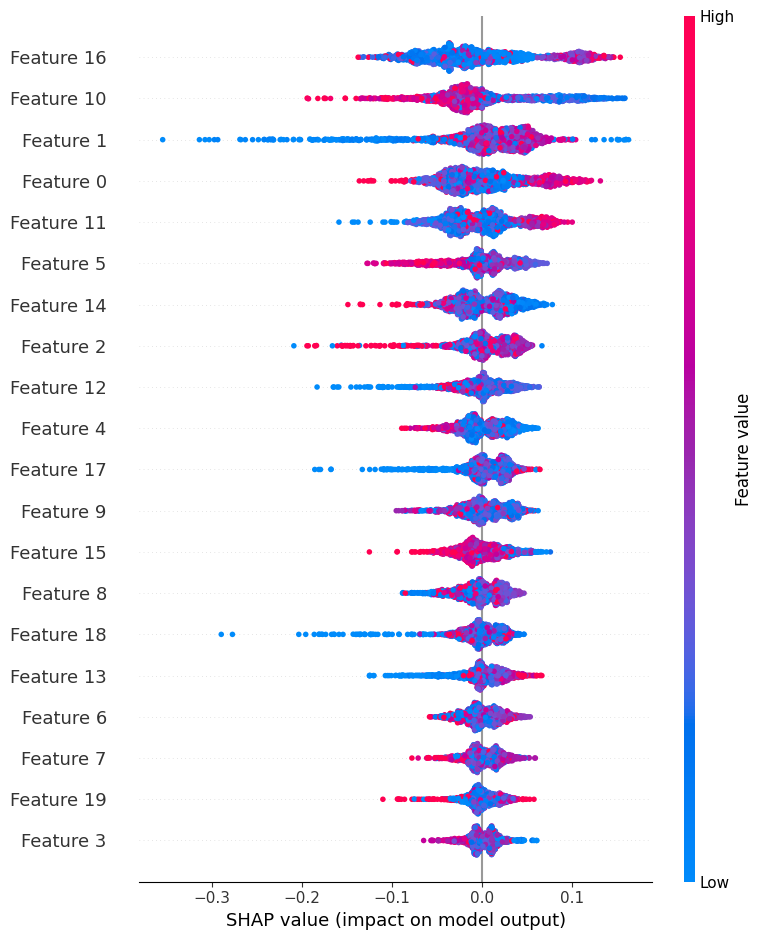

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Plot SHAP summary plot for class 1
    shap.summary_plot(shap_values_class1, X_train_selected)

# List of files to process
files = [
    r'E:\Label_2.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_'

# Process each file
for file in files:
    process_file(file, output_directory)


c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing file: E:\Label_2.xlsx
Label distribution:
 label
0    1096
1     167
Name: count, dtype: int64
ROC curve saved to E:\result_\Label_2.xlsx_roc_curve.png
t-SNE plot saved to E:\result_\Label_2.xlsx_tsne_plot.png


PermutationExplainer explainer: 1753it [16:46,  1.73it/s]                          


X_train shape: (1752, 20)
shap_values.values shape: (1752, 20, 2)


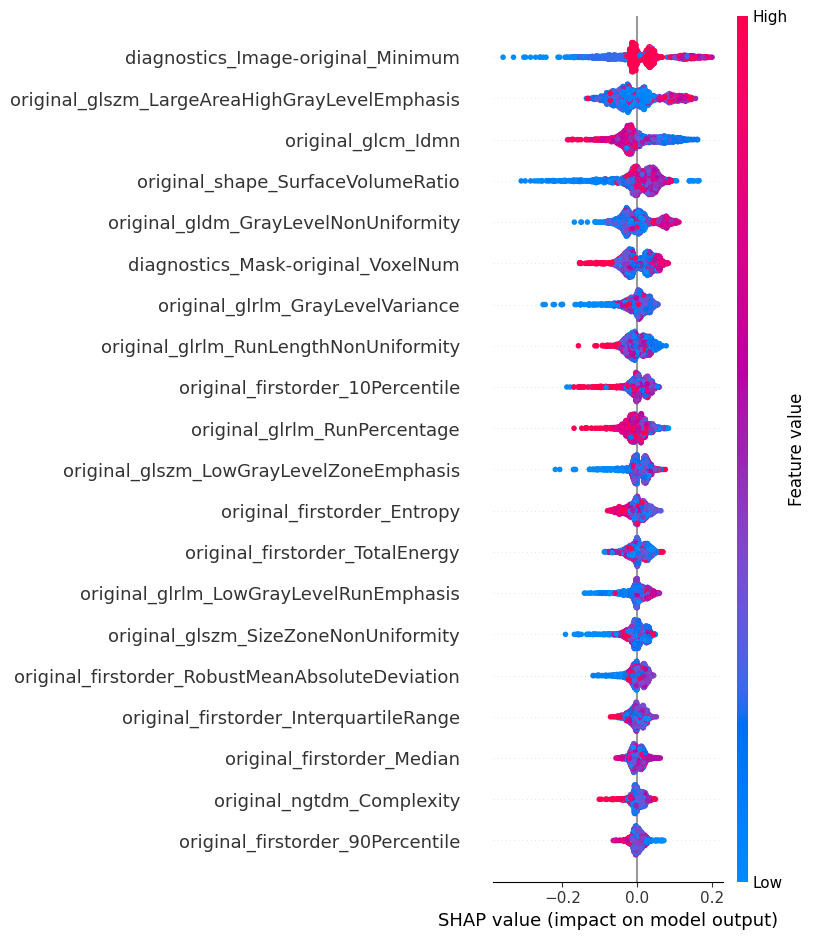

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('common bile duct label')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'E:\Label_2.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_'

# Process each file
for file in files:
    process_file(file, output_directory)


c:\Users\alire\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing file: E:\Label_3.xlsx
Label distribution:
 label
0    1096
1     166
Name: count, dtype: int64
ROC curve saved to E:\result_3\Label_3.xlsx_roc_curve.png
t-SNE plot saved to E:\result_3\Label_3.xlsx_tsne_plot.png


PermutationExplainer explainer: 1753it [11:29,  2.52it/s]                          


X_train shape: (1752, 20)
shap_values.values shape: (1752, 20, 2)


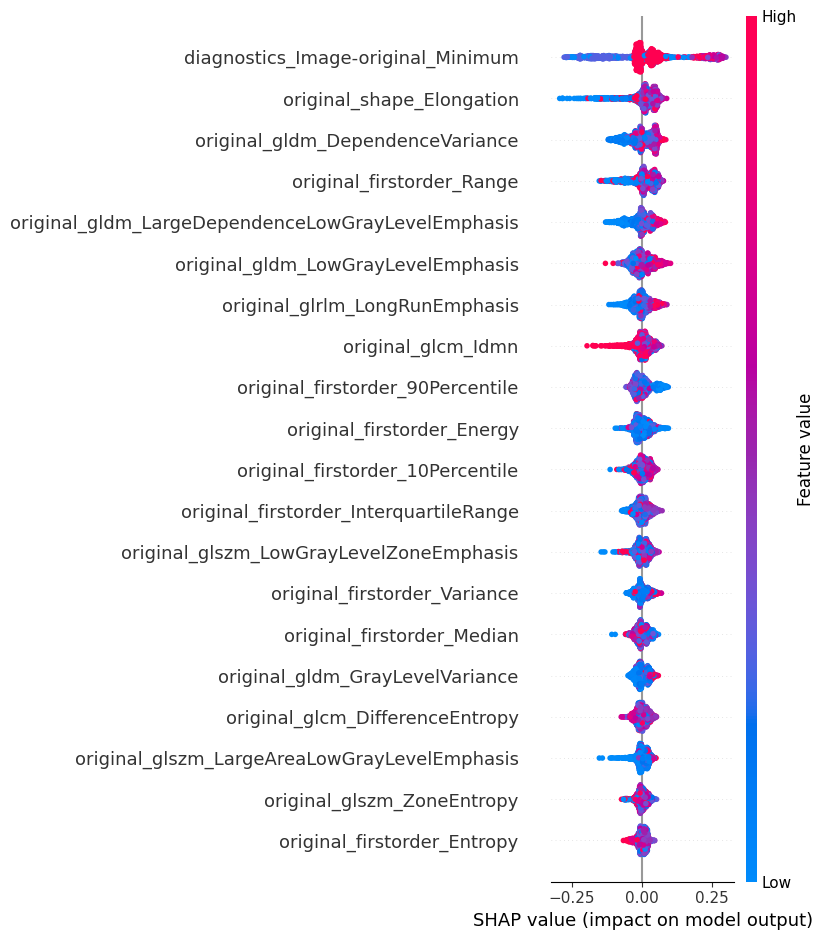

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('Arteries label')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'E:\Label_3.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_3'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: E:\Label_4.xlsx
Label distribution:
 label
0    1096
1     166
Name: count, dtype: int64
ROC curve saved to E:\result_4\Label_4.xlsx_roc_curve.png
t-SNE plot saved to E:\result_4\Label_4.xlsx_tsne_plot.png


PermutationExplainer explainer: 1753it [11:04,  2.60it/s]                          


X_train shape: (1752, 20)
shap_values.values shape: (1752, 20, 2)


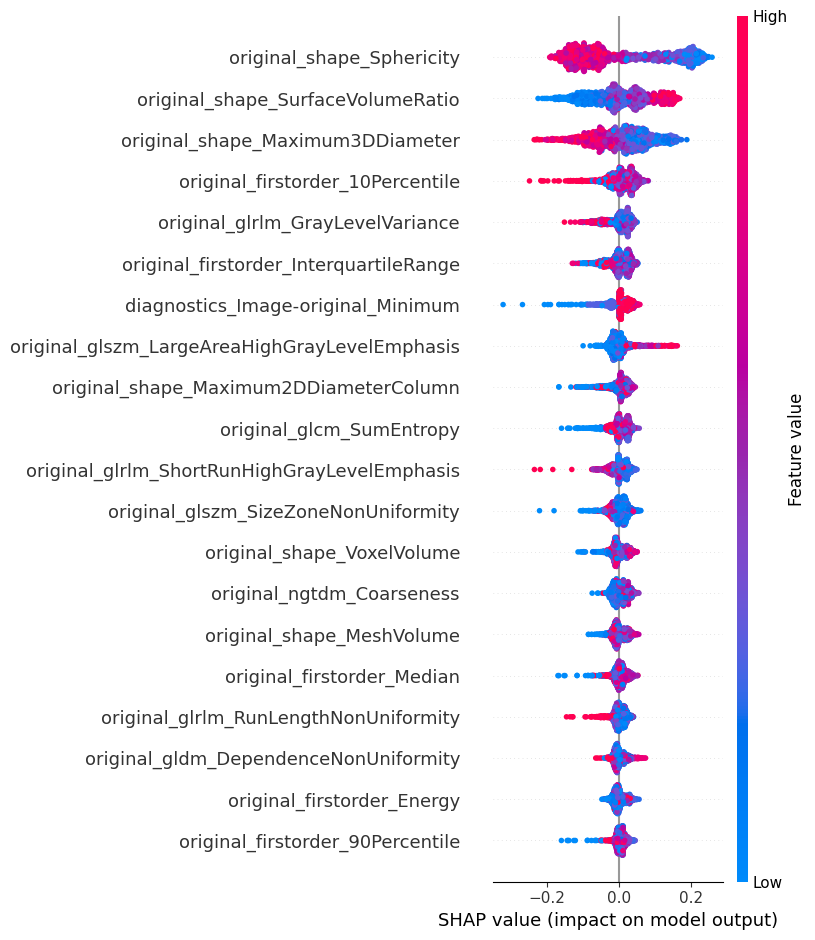

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'E:\Label_4.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_4'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: E:\Label_6.xlsx
Label distribution:
 label
0    965
1    156
Name: count, dtype: int64
ROC curve saved to E:\result_6\Label_6.xlsx_roc_curve.png
t-SNE plot saved to E:\result_6\Label_6.xlsx_tsne_plot.png


PermutationExplainer explainer: 1543it [10:27,  2.43it/s]                          


X_train shape: (1542, 20)
shap_values.values shape: (1542, 20, 2)


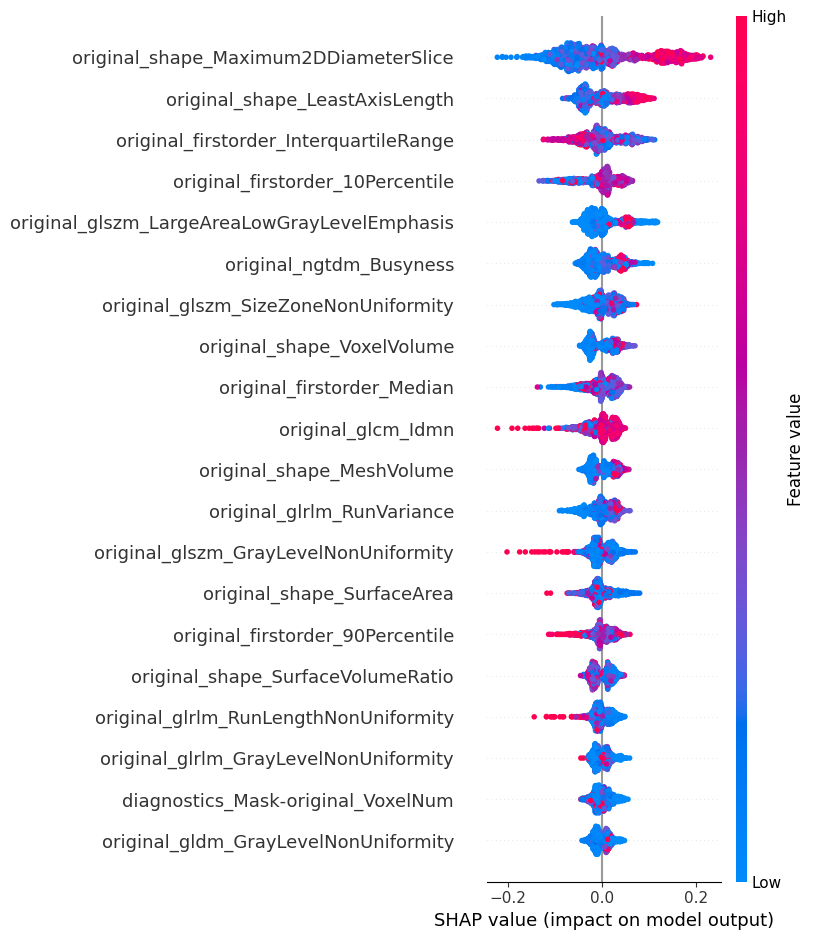

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'E:\Label_6.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_6'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: E:\label 5.xlsx
Label distribution:
 label
0    817
1    158
Name: count, dtype: int64
ROC curve saved to E:\result_5\label 5.xlsx_roc_curve.png
t-SNE plot saved to E:\result_5\label 5.xlsx_tsne_plot.png


PermutationExplainer explainer: 1309it [07:29,  2.84it/s]                          


X_train shape: (1308, 20)
shap_values.values shape: (1308, 20, 2)


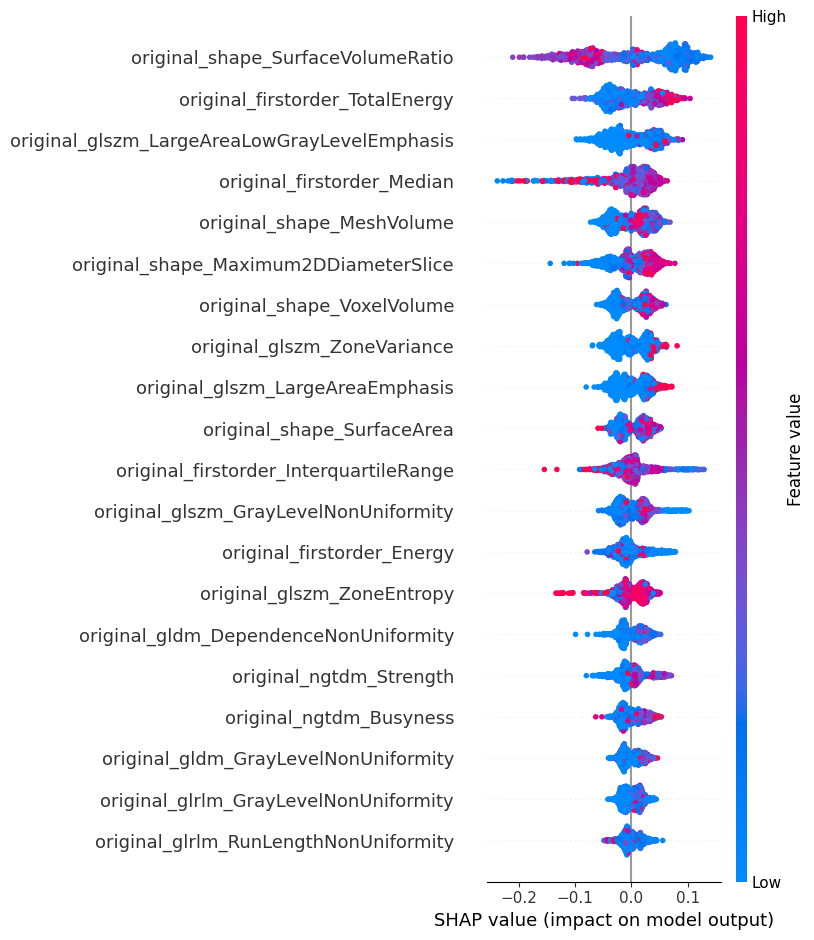

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'E:\label 5.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_5'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: c:\Users\alire\Downloads\step 3 excel (1) - Copy_new.xlsx
Label distribution:
 label
0    540
1    101
Name: count, dtype: int64
ROC curve saved to E:\result_5\step 3 excel (1) - Copy_new.xlsx_roc_curve.png
t-SNE plot saved to E:\result_5\step 3 excel (1) - Copy_new.xlsx_tsne_plot.png


PermutationExplainer explainer: 863it [04:47,  2.89it/s]                         


X_train shape: (862, 20)
shap_values.values shape: (862, 20, 2)


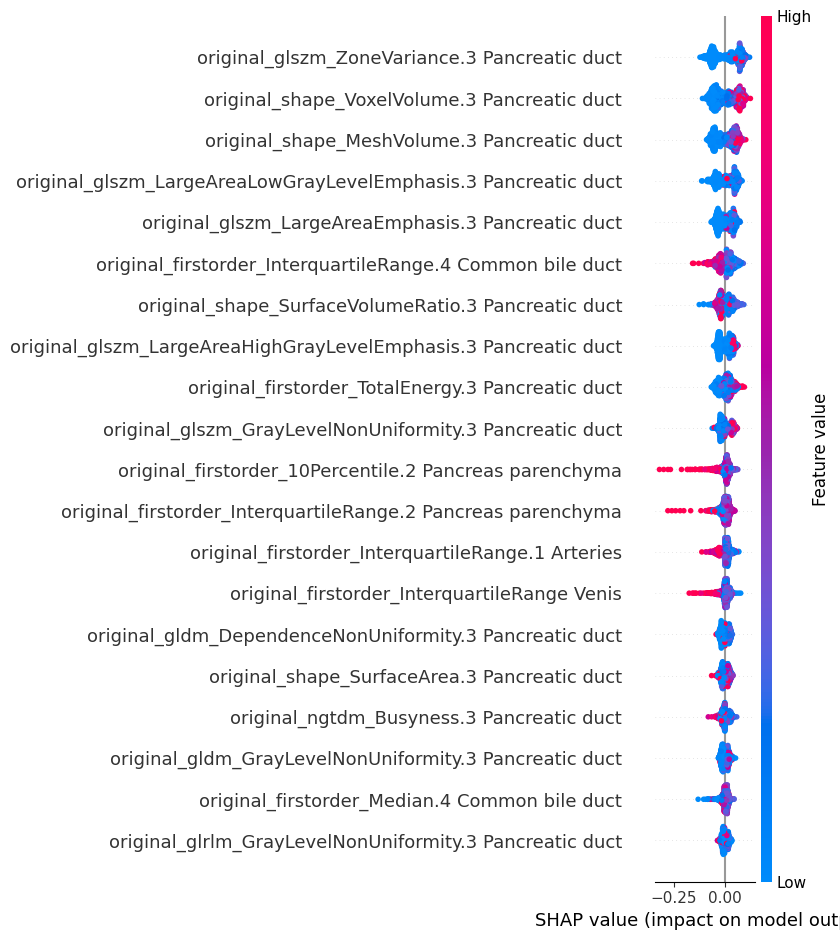

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)



# List of files to process
files = [
    r'c:\Users\alire\Downloads\step 3 excel (1) - Copy_new.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_5'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: c:\Users\alire\Downloads\step 3 excel (1) - Copy_new.xlsx
Label distribution:
 label
0    540
1    101
Name: count, dtype: int64
ROC curve saved to E:\result_5\step 3 excel (1) - Copy_new.xlsx_roc_curve.png
t-SNE plot saved to E:\result_5\step 3 excel (1) - Copy_new.xlsx_tsne_plot.png


PermutationExplainer explainer: 863it [05:32,  2.54it/s]                         


X_train shape: (862, 20)
shap_values.values shape: (862, 20, 2)


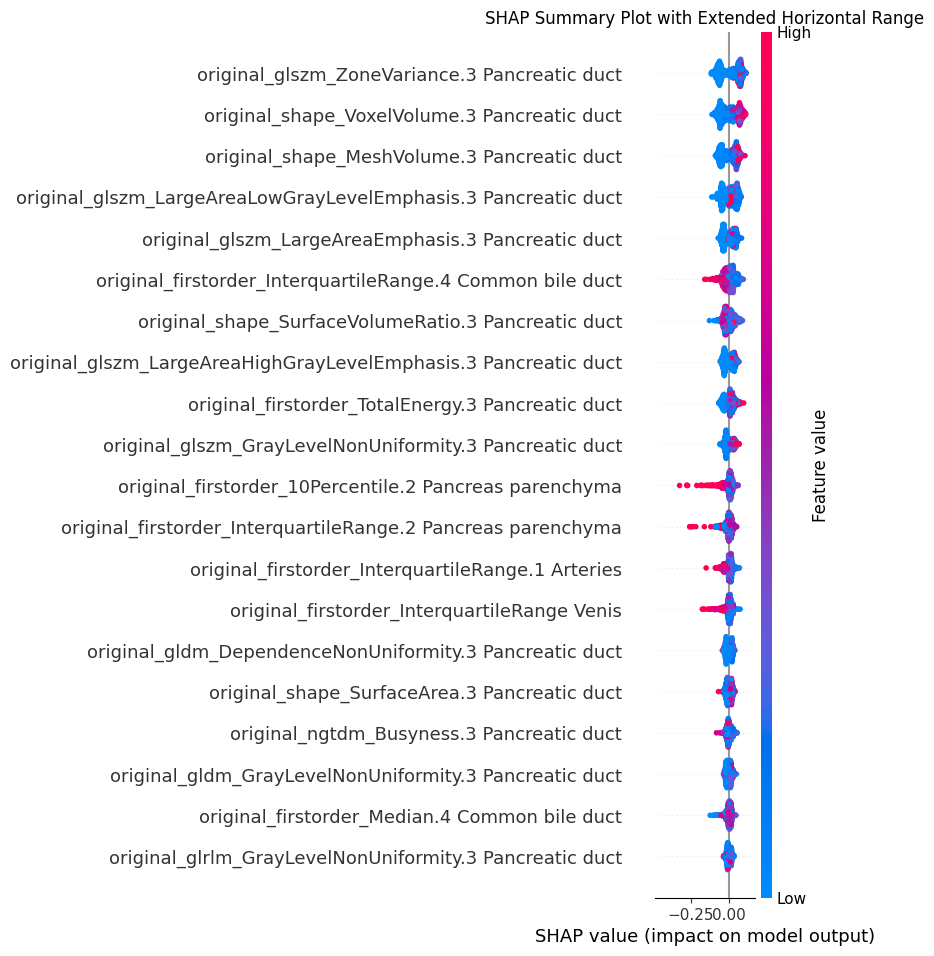

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os
import numpy as np

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['label'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['label'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['label']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20  # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    # Create an explainer based on our classifier and training data
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, extract SHAP values for class 1
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names based on the selected features
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    # Set show=False to allow further modifications before display
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names, show=False)

    # Adjust the horizontal (x-axis) limits to extend the range
    ax = plt.gca()
    min_shap = np.min(shap_values_class1.values)
    max_shap = np.max(shap_values_class1.values)

    # Define an extension factor (e.g., extend range by 50%)
    extension_factor = 1.5
    new_xlim = (min_shap * extension_factor, max_shap * extension_factor)
    ax.set_xlim(new_xlim)

    # Optionally add a title to the plot
    plt.title("SHAP Summary Plot with Extended Horizontal Range")

    # Display the modified SHAP summary plot
    plt.show()

# List of files to process
files = [
    r'c:\Users\alire\Downloads\step 3 excel (1) - Copy_new.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_5'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: c:\Users\alire\Downloads\combinedoutput.xlsx
Label distribution:
 Cancer Status
0    3830
1     706
Name: count, dtype: int64
ROC curve saved to E:\result_5\combinedoutput.xlsx_roc_curve.png
t-SNE plot saved to E:\result_5\combinedoutput.xlsx_tsne_plot.png


PermutationExplainer explainer: 6127it [59:52,  1.70it/s]                            


X_train shape: (6126, 20)
shap_values.values shape: (6126, 20, 2)


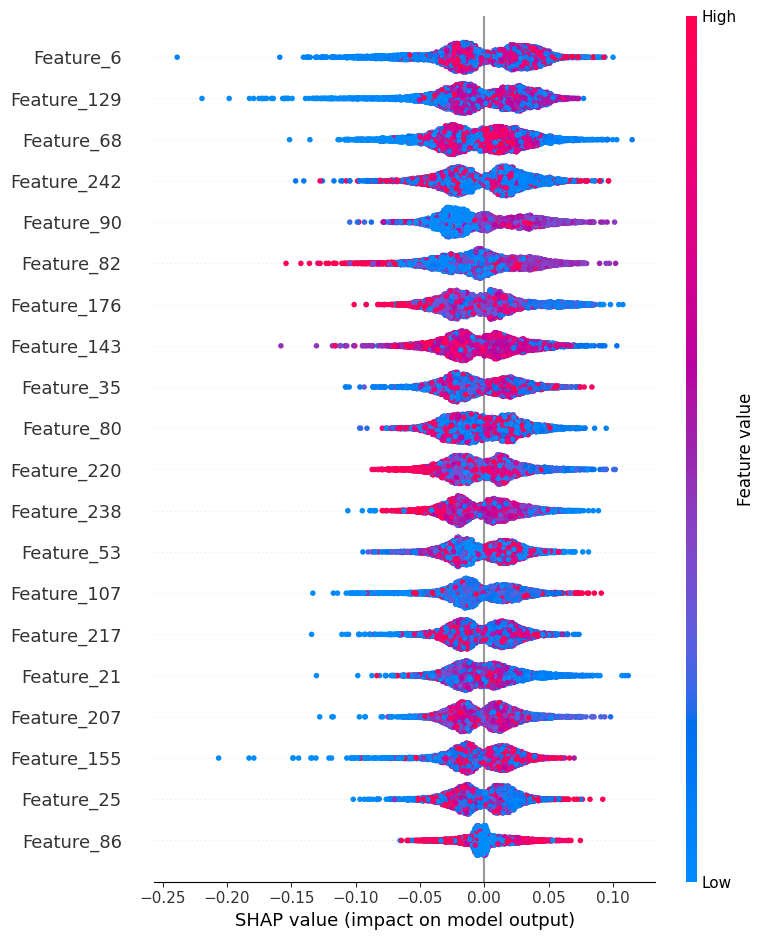

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['Cancer Status'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['Patient ID'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['Cancer Status'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['Cancer Status']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'c:\Users\alire\Downloads\combinedoutput.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_5'

# Process each file
for file in files:
    process_file(file, output_directory)

Processing file: c:\Users\alire\Downloads\labelstep3 (1) new.xlsx
Label distribution:
 Cancer Status
0    435
1     93
Name: count, dtype: int64
ROC curve saved to E:\result_5\labelstep3 (1) new.xlsx_roc_curve.png
t-SNE plot saved to E:\result_5\labelstep3 (1) new.xlsx_tsne_plot.png


PermutationExplainer explainer: 697it [05:46,  1.93it/s]                         


X_train shape: (696, 20)
shap_values.values shape: (696, 20, 2)


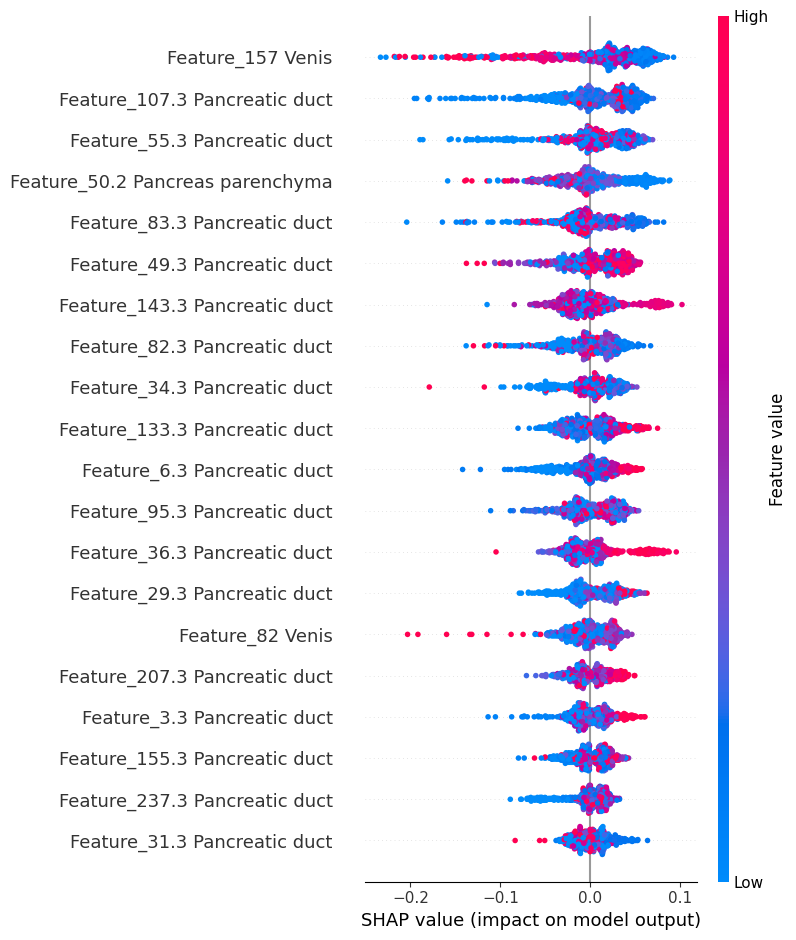

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import shap
import os

# Function to process each file
def process_file(file_path, output_dir):
    data = pd.read_excel(file_path)

    # 2. Check label distribution
    label_distribution = data['Cancer Status'].value_counts()
    print(f"Processing file: {file_path}")
    print("Label distribution:\n", label_distribution)

    # 3. Drop irrelevant columns
    data_cleaned = data.drop(columns=['Label'])

    # 4. Convert non-numeric columns to numeric using one-hot encoding
    X = data_cleaned.drop(columns=['Cancer Status'])
    X = pd.get_dummies(X, drop_first=True)
    y = data_cleaned['Cancer Status']

    # 5. Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # 6. Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

    # 7. Feature Selection
    k = 20 # Number of features to select
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_balanced, y_train_balanced)
    X_test_selected = selector.transform(X_test)

    selected_features = X.columns[selector.get_support()]

    # 8. Train a Random Forest Classifier with class weights
    class_weights = {0: 1, 1: 5}
    clf = RandomForestClassifier(class_weight=class_weights, random_state=42)
    clf.fit(X_train_selected, y_train_balanced)

    # Make predictions
    y_pred = clf.predict(X_test_selected)

    # Evaluate the model
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_selected)[:, 1])

    # Save results to Excel
    results = pd.DataFrame(report).T
    results['confusion_matrix'] = str(confusion)
    results['roc_auc'] = roc_auc

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save selected features
    pd.DataFrame(selected_features, columns=["Selected Features"]).to_excel(
        os.path.join(output_dir, f"{os.path.basename(file_path)}_features.xlsx"), index=False)

    # Save classification report
    results.to_excel(os.path.join(output_dir, f"{os.path.basename(file_path)}_metrics.xlsx"), index=True)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test_selected)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_curve_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_roc_curve.png")
    plt.savefig(roc_curve_path)
    plt.close()
    print(f"ROC curve saved to {roc_curve_path}")

    # t-SNE Plot
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_test_selected)
    plt.figure()
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, cmap='viridis', alpha=0.5)
    plt.title('t-SNE Plot')
    plt.colorbar(scatter)
    tsne_plot_path = os.path.join(output_dir, f"{os.path.basename(file_path)}_tsne_plot.png")
    plt.savefig(tsne_plot_path)
    plt.close()
    print(f"t-SNE plot saved to {tsne_plot_path}")

    # SHAP Analysis
    explainer = shap.Explainer(clf.predict_proba, X_train_selected)
    shap_values = explainer(X_train_selected)

    print('X_train shape:', X_train_selected.shape)
    print('shap_values.values shape:', shap_values.values.shape)

    # For multi-class models, choose the class of interest (e.g., class 1)
    shap_values_class1 = shap_values[:, :, 1]

    # Feature names
    feature_names = X.columns[selector.get_support()]

    # Plot SHAP summary plot for class 1 with feature names
    shap.summary_plot(shap_values_class1, X_train_selected, feature_names=feature_names)

# List of files to process
files = [
    r'c:\Users\alire\Downloads\labelstep3 (1) new.xlsx'
]

# Directory to save outputs
output_directory = r'E:\result_5'

# Process each file
for file in files:
    process_file(file, output_directory)